# Setup


In [ ]:
# Libraries
# Warning: This takes a while, take a break while running this line
install.packages("car")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’




In [ ]:
# Auth and mount google drive
googledrive::drive_auth(use_oob = TRUE, cache = TRUE)

The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: ajowe@ucdavis.edu


Selection: 2


In [ ]:
# Name of the file in the home folder of google drive
file_name <- "Salary.csv"

# Find the file in Google Drive (search in the root directory)
file_info <- googledrive::drive_find(file_name)

# Check if the file was found
if (length(file_info) > 0) {
  # Get the file ID
  file_id <- file_info$id

  # Download the file to the current working directory
  googledrive::drive_download(googledrive::as_id(file_id))
} else {
  cat("File not found in Google Drive.")
}

Auto-refreshing stale OAuth token.



ERROR: Error: Path exists and overwrite is FALSE


# I Introduction

In [ ]:
# Read the data from the downloaded file
data <- read.csv(file_name)
head(data)

In [ ]:
# Give me means
find.means = function(the.data,fun.name = mean){
  a = length(unique(the.data[,2]))
  b = length(unique(the.data[,3]))
  means.A = by(the.data[,1], the.data[,2], fun.name)
  means.B = by(the.data[,1],the.data[,3],fun.name)
  means.AB = by(the.data[,1],list(the.data[,2],the.data[,3]),fun.name)
  MAB = matrix(means.AB,nrow = b, ncol = a, byrow = TRUE)
  colnames(MAB) = names(means.A)
  rownames(MAB) = names(means.B)
  MA = as.numeric(means.A)
  names(MA) = names(means.A)
  MB = as.numeric(means.B)
  names(MB) = names(means.B)
  MAB = t(MAB)
  results = list(A = MA, B = MB, AB = MAB)
  return(results)
}

# Get all means for context
# all.means <- find.means(the.data)
# the.means <- data.frame(all.means$AB)
# the.means$Avg <- all.means$A
# the.means <- rbind(the.means, Avg = c(unlist(all.means$B), "NA"))

,S,SF,Avg
,<chr>,<chr>,<chr>
BE,79.75485,82.4191421936352,81.0869960968176
DS,112.52715,117.768832413411,115.147991206706
SE,95.54875,110.264123216383,102.906436608192
Avg,95.9435833333333,103.48403260781,NA


Question: How does the annual salary (USD) vary between different professions (Data Scientist, Software Engineer, Bioinformatics Engineer) across different regions (San Francisco and Seattle)?

Interest: Understanding the salary distribution across professions and regions can provide insightful economic. Insights into wage can help individuals make informed decisions about career paths and relocation opportunities. Additionally, businesses and governments can use this information to strategize their hiring plans and economic policies respectively.

Approach: Two Factor ANOVA (TFA)

# III Diagnostics

In this section, we will check whether our data satisfies the ANOVA assumptions.

The assumptions are:
1. All samples are independent
2. All groups in factor $A$ are independent
3. All groups in factor $B$ are independent
4. Errors are normally distributed and have constant variance where $ϵ_{ij} \sim N(0, \sigma_\epsilon^2)$

Due to limitations, we can only test whether the errors are normally distributed and have constant variance. We cannot determine whether assumptions one through three are satisfied as we did not sample the data. For simplicity, we will assume these hold.

In [ ]:
# Get model
the.model <- lm(Annual ~ Prof + Region, data = data)
the.residuals <- residuals(the.model)

## III.1 Assessing Type I and Type II Errors

To determine which $\alpha$ to use for diagnostics, we need to assess whether we want to minimize the chance of a Type I Error or a Type II Error.

- Type I Error: When you reject $H_0$ when in reality $H_0$ is true. In this case, this represents the chance we conclude the data violates our ANOVA assumptions when in reality it satisfies our ANOVA assumptions.
- Type II Error: When you accept $H_0$ when in reality $H_0$ is false. In this case, this represents the chance we conclude the data satisfies our ANOVA assumptions when in reality it violates our ANOVA assumptions

For determining normality and constant variance, we want to minimize our probability of incorrect assumptions, so a Type II error is worse than a Type I error. As a result, we want to maximize $\alpha$, so we will use $\alpha = 0.1$ as our threshold.

## III.2 Determine Normality

### III.2.1 QQ Plot

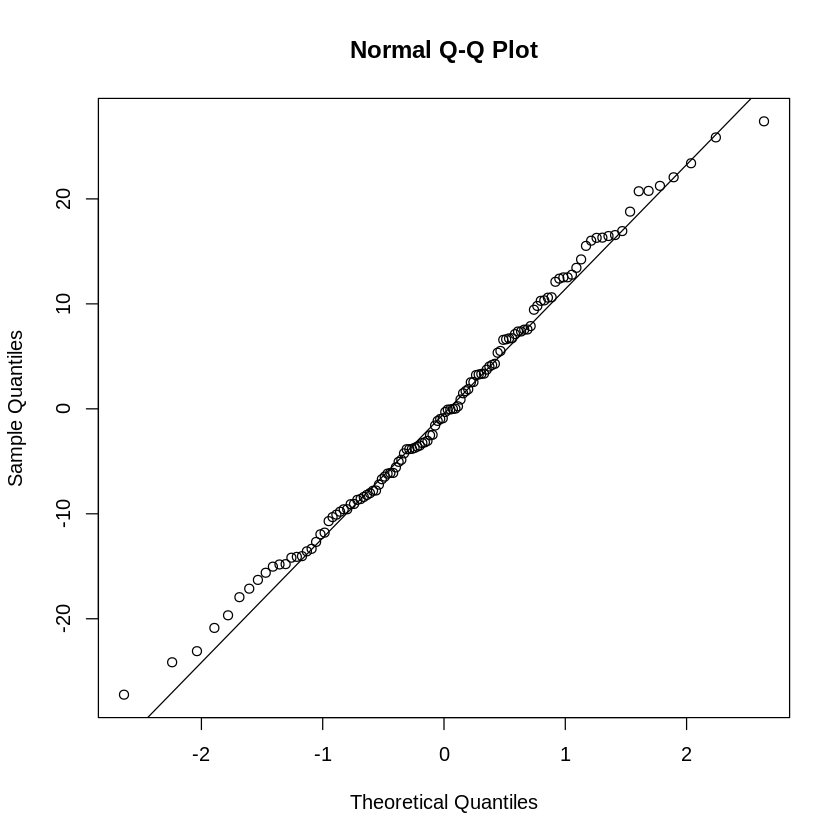

In [ ]:
# Do QQ Plot
qqnorm(the.residuals, main = "Figure 3.2.1 - Normal Q-Q Plot")
qqline(the.residuals)

The QQ plot shows our original data plotted against a theoretical normal distribution. From the plot, the majority of the data points converge to the normal line, suggesting that our data is most likely normal. We formalize this plot by running a Shapiro-Wilk Test next.

### III.2.2 Shapiro Wilk Test

In [ ]:
the.SWtest <- shapiro.test(the.residuals)
# the.SWtest


	Shapiro-Wilk normality test

data:  the.residuals
W = 0.99146, p-value = 0.6698


$H_0:$ Our data is normal.

$H_a:$ Our data is not normal.

$p = 0.6698$

Since $p > \alpha$, we accept $H_0$. Therefore, our data is normal.

## III.3 Assessing Constant Variance

### III.3.1 Plot on Errors vs Groups Means

In [1]:
# Do plot
plot(the.model$fitted.values, the.residuals,
     main = "Figure 3.3.1 Errors vs. Group Means",
     xlab = "Group Means",
     ylab = "Errors")

abline(h = 0,col = "purple")

ERROR: Error in eval(expr, envir, enclos): object 'the.model' not found


From figure 3.3.1, the dots for each group mean seem to have approximately the same spread, suggesting that there is constant variance between groups. To formalize this, we will run the BF-test next.

### III.3.2 BF-Test

In [ ]:
# Do BF-test
the.BFtest <- car::leveneTest(the.residuals ~ paste(Prof, Region), data=data,
                              center=median)
the.p.val <- the.BFtest[[3]][1]
# the.p.val

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


[1] 0.3048319

$H_0:$ The data have constant variances.

$H_a:$ The data does not have constant variances.

Since $p = 0.3048 > \alpha$, we accept $H_0$. Therefore, the data has constant variances.

## III.4 Final Verdict

We can conclude that the errors are normally distributed and have constant variances, satisfying one of our ANOVA assumptions. No transformation nor outlier removal is needed.

# IV Analysis and Interpretation

## IV.1 Finding Best Model

We will first observe the conditional $R^2$ and differences between mean values to see what to expect. Then we will use F-statistic test to find out which model to use. When conducting our test, we will first test for interaction effect. If there is interaction effect, we use the model with interaction effect and stop the testing. Otherwise, we will continue testing for factor A and factor B. We will only use these factors if there are significant effects.

### IV.1.1 Conditional $R^2$

**Figure 4.1.1**

In [ ]:
# Rename for more efficient typing
the.data <- data
names(the.data) <- c("Y", "A", "B")

# Fit the models
AB <- lm(Y ~ A * B, the.data)
A.B = lm(Y ~ A + B,the.data)
A = lm(Y ~ A,the.data)
B = lm(Y ~ B,the.data)
N = lm(Y ~ 1, the.data)

# Find the SSE values
all.models = list(AB,A.B,A,B,N)
SSE = t(as.matrix(sapply(all.models,function(M) sum(M$residuals^2))))
colnames(SSE) = c("AB","(A+B)","A","B","Empty/Null")
rownames(SSE) = "SSE"
round(SSE, 4)

,AB,(A+B),A,B,Empty/Null
SSE,15252.93,16058.34,17764.09,39872.94,41578.69


$R^2(AB|(A+B))$,$R^2((A+B)|A)$,$R^2((A+B)|B)$,$R^2(A|Empty)$,$R^2(B|Empty)$
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0501551,0.09602243,0.5972622,0.5727597,0.04102465


**Figure 4.1.2**

In [ ]:
# Get partial R^2
get.Partial.R2 = function(small.model,big.model){
  SSE1 = sum(small.model$residuals^2)
  SSE2 = sum(big.model$residuals^2)
  PR2 = (SSE1 - SSE2)/SSE1
  return(PR2)
}

the.partial.R2 <- data.frame(get.Partial.R2(A.B, AB), get.Partial.R2(A, A.B),
                               get.Partial.R2(B, A.B), get.Partial.R2(N, A),
                               get.Partial.R2(N, B))
colnames(the.partial.R2) <- c("$R^2(AB|(A+B))$", "$R^2((A+B)|A)$",
                              "$R^2((A+B)|B)$", "$R^2(A|Empty)$",
                              "$R^2(B|Empty)$")
round(the.partial.R2, 4)

From figure 4.1.2, there seems to be a significant factor A effect since its $R^2$ value is large when adding it both to the empty model and the model with factor B. While the conditional $R^2$ may hint which factors may be significant, this is not a conclusive test.

### IV.1.2 Assessing Type I and Type II Errors

To determine which $\alpha$ to use for diagnostics, we need to assess whether we want to minimize the chance of a Type I Error or a Type II Error.

Type I Error: The chance we reject $H_0$ when in reality $H_0$ is true. In this case, it is the chance we conclude that there is a significant effect when in reality there is no significant effect.

Type II Error: The chance that we accept $H_0$ when in reality $H_0$ is false. In this case, it is the chance we conclude that there is no significant effect when in reality there is a significant effect.

In our analysis, we want to capture the factor and interaction effects if it exists, and thus want to minimize unexplained error. The lower the Type II Error, the less chance of falsely concluding no significant effect, increasing the chance of less unexplained error. Since a type II error is worse, we want to minimize it, so we will choose a higher $\alpha$ value. As a result, we will choose $\alpha = 0.1$.

### IV.1.3 Testing for Interaction Effect

Our full model is $Y_{ijk} = \mu_{ij} + \gamma_i + \delta_j + (\gamma\delta)_{ij} + \epsilon_{ijk}$

With constraints:
- $\sum \gamma_i = 0$
- $\sum \delta_j = 0$
- $\sum \sum (\gamma_i \delta_j) = 0$

Our reduced model is $Y_{ijk} = \mu_{ij} + \gamma_i + \delta_j + \epsilon_{ijk}$

With constraints:
- $\sum \gamma_i = 0$
- $\sum \delta_j = 0$

Hypothesis:
- $H_0:$ There is no significant interaction effect (i.e. all $(\gamma\delta)_{ij} = 0$). Do not use the full model.
- $H_a:$ There is significant interaction effect (i.e. at least one $(\gamma\delta)_{ij} \neq 0$). Use the full model.

In [ ]:
# Interaction effect test
# anova(A.B, AB)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,116,16058.34,NA,NA,NA,NA
2,114,15252.93,2,805.4077,3.009798,0.05323577


Test results:
- $F_s = 3.0098$
- $p = 0.0532$

Since $p \leq \alpha$, we reject $H_0$. Therefore, we will use the full model.

### IV.1.4 Model Choice

From our testing, our final model choice is $Y_{ijk} = \mu_{ij} + \gamma_i + \delta_j + (\gamma \delta)_{ij} + \epsilon{ijk}$

With constraints:
- $\sum \gamma_i = 0$
- $\sum \delta_j = 0$
- $\sum \sum (\gamma_i \delta_j) = 0$

## IV.2 Comparisons of Different Factors

First, we will create pairwise confidence intervals to test how much professions affects average annual salary. Then, we will create another pairwise interval to test how much region affects average annual salary. Lastly, we will create non-pairwise intervals to test for more complex differences.

In [ ]:
# Get relavent values for CI based on model choice
n_T <- nrow(the.data)
a <- length(unique(the.data$A))
b <- length(unique(the.data$B))
sse <- SSE["SSE", "AB"]
df_sse <- n_T - a * b
mse <- sse / df_sse
alpha <- 0.001

# Give me multipliers
find.mult = function(alpha,a,b,dfSSE,g,group){
  if(group == "A"){
  Tuk = round(qtukey(1-alpha,a,dfSSE)/sqrt(2),3)
  Bon = round(qt(1-alpha/(2*g), dfSSE ) ,3)
  Sch = round(sqrt((a-1)*qf(1-alpha, a-1, dfSSE)),3)
  }else if(group == "B"){
  Tuk = round(qtukey(1-alpha,b,dfSSE)/sqrt(2),3)
  Bon = round(qt(1-alpha/(2*g), dfSSE ) ,3)
  Sch = round(sqrt((b-1)*qf(1-alpha, b-1, dfSSE)),3)
  }else if(group == "AB"){
  Tuk = round(qtukey(1-alpha,a*b,dfSSE)/sqrt(2),3)
  Bon = round(qt(1-alpha/(2*g), dfSSE ) ,3)
  Sch = round(sqrt((a*b-1)*qf(1-alpha, a*b-1, dfSSE)),3)
  }
  results = c(Bon, Tuk,Sch)
  names(results) = c("Bonferroni","Tukey","Scheffe")
  return(results)
}

# Give me CI
give.me.CI = function(the.data,MSE,equal.weights = TRUE,multiplier,group,cs){
   if(sum(cs) != 0 & sum(cs !=0 ) != 1){
    return("Error - you did not input a valid contrast")
  }else{
    the.means = find.means(the.data)
    the.ns =find.means(the.data,length)
    nt = nrow(the.data)
    a = length(unique(the.data[,2]))
    b = length(unique(the.data[,3]))
    if(group =="A"){
      if(equal.weights == TRUE){
        a.means = rowMeans(the.means$AB)
        est = sum(a.means*cs)
        mul = rowSums(1/the.ns$AB)
        SE = sqrt(MSE/b^2 * (sum(cs^2*mul)))
        N = names(a.means)[cs!=0]
        CS = paste("(",cs[cs!=0],")",sep = "")
        fancy = paste(paste(CS,N,sep =""),collapse = "+")
        names(est) = fancy
      } else{
        a.means = the.means$A
        est = sum(a.means*cs)
        SE = sqrt(MSE*sum(cs^2*(1/the.ns$A)))
        N = names(a.means)[cs!=0]
        CS = paste("(",cs[cs!=0],")",sep = "")
        fancy = paste(paste(CS,N,sep =""),collapse = "+")
        names(est) = fancy
      }
    }else if(group == "B"){
      if(equal.weights == TRUE){
        b.means = colMeans(the.means$AB)
        est = sum(b.means*cs)
        mul = colSums(1/the.ns$AB)
        SE = sqrt(MSE/a^2 * (sum(cs^2*mul)))
        N = names(b.means)[cs!=0]
        CS = paste("(",cs[cs!=0],")",sep = "")
        fancy = paste(paste(CS,N,sep =""),collapse = "+")
        names(est) = fancy
      } else{
        b.means = the.means$B
        est = sum(b.means*cs)
        SE = sqrt(MSE*sum(cs^2*(1/the.ns$B)))
        N = names(b.means)[cs!=0]
        CS = paste("(",cs[cs!=0],")",sep = "")
        fancy = paste(paste(CS,N,sep =""),collapse = "+")
        names(est) = fancy
      }
    } else if(group == "AB"){
      est = sum(cs*the.means$AB)
      SE = sqrt(MSE*sum(cs^2/the.ns$AB))
      names(est) = "someAB"
    }
    the.CI = est + c(-1,1)*multiplier*SE
    results = c(est,the.CI)
    names(results) = c(names(est),"lower bound","upper bound")
    return(results)
  }
}

### IV.2.1 Accuracy

We want to minimize the error of our confidence interval for stronger interpretation. As a result, we want to minimize the probability that the value does not lie within our confidence interval by minimizing $\alpha$. Therefore, we will choose $\alpha = 0.001$.

### IV.2.2 Multiplier

We will compute 3 pairwise confidence intervals for group A and 1 pairwise confidence interval for group B to determine the difference in annual salary given the difference in profession or region. For these intervals, we can use either the Bonferonni, Tukey, or Scheffe multipliers. We will pick the smallest multiplier for higher precision.

We will also compute 2 non-pairwise confidence intervals. For these intervals, we cannot use Tukey since that is for pairwise comparisons only. We will pick either Bonferonni or Scheffe, whichever one is smaller.

### IV.2.3 Effect of Profession on Average Annual Salary

We will analyze the difference in average annual salary between all professions.

In [ ]:
# Give me multiplier for pairwise comparisons between different professions
all.mult <- find.mult(alpha = alpha, a = a, b = b, dfSSE = df_sse, g = 3,
                      group = "A")
the.mult <- min(all.mult)

In [ ]:
# Give me CI for BE vs DS
the.CI <- give.me.CI(the.data, mse, equal.weights = TRUE, the.mult, "A",
                     c(1, -1, 0))
names(the.CI) <- c("$\\mu_{1.} - \\mu_{2.}$", "lower bound", "upper bound")
# data.frame(the.CI)

,the.CI
,<dbl>
$\mu_{1.} - \mu_{2.}$,-34.06100
lower bound,-43.60511
upper bound,-24.51688


Our 99.9% confidence interval for the difference of average annual salary between BE (bioinformatics engineer) and DS (data scientist) is $[-43.6051, -24.5169]$. This means that we are 99.9% confident that on average BE makes around 24.5169 to 43.6051 less annually compared to DS. Since 0 is not in our confidence interval, we are 99.9% certain that there is a difference in average annual salary between BE and DS (i.e. BS makes less than DS).

In [ ]:
# Give me CI for DS vs SE
the.CI <- give.me.CI(the.data, mse, equal.weights = TRUE, the.mult, "A",
                     c(0, 1, -1))
names(the.CI) <- c("$\\mu_{2.} - \\mu_{3.}$", "lower bound", "upper bound")
# data.frame(the.CI)

,the.CI
,<dbl>
$\mu_{2.} - \mu_{3.}$,12.241555
lower bound,2.697441
upper bound,21.785669


Our 99.9% confidence interval for the difference of average annual salary between DS and SE (software engineer) is $[2.6974, 21.7856]$. This means that we are 99.9% confident that on average DS makes around 2.6974 and 21.7856 more annually compared to SE. Since 0 is not in our confidence interval, we are 99.9% certain that there is a difference in average annual salary between DS and SE (i.e. DS makes more than SE).

In [ ]:
# Give me CI for BE vs SE
the.CI <- give.me.CI(the.data, mse, equal.weights = TRUE, the.mult, "A",
                     c(1, 0, -1))
names(the.CI) <- c("$\\mu_{1.} - \\mu_{3.}$", "lower bound", "upper bound")
# data.frame(the.CI)

,the.CI
,<dbl>
$\mu_{1.} - \mu_{3.}$,-21.81944
lower bound,-31.36355
upper bound,-12.27533


Our 99.9% confidence interval for the average difference of annual salary between BE and SE is $[-31.3635, -12.2753]$. This means that we are 99.9% confident that on average BE makes around 12.2753 and 31.3635 less annually compared to SE. Since 0 is not in our confidence interval, we are 99.9% certain that there is a difference in average annual salary between BE and SE (i.e. BE makes more than SE).

### IV.2.4 Effect of Region on Average Annual Salary

We will analyze the difference of average annual salary between S and SF.

In [ ]:
# Give me multiplier for pairwise comparisons between different regions
all.mult <- find.mult(alpha = alpha, a = a, b = b, dfSSE = df_sse, g = 1,
                      group = "B")
the.mult <- min(all.mult)

In [ ]:
# Give me CI for S vs SF
the.CI <- give.me.CI(the.data, mse, equal.weights = TRUE, the.mult, "B",
                     c(1, -1))
names(the.CI) <- c("$\\mu_{.1} - \\mu_{.2}$", "lower bound", "upper bound")
# data.frame(the.CI)

,the.CI
,<dbl>
$\mu_{.1} - \mu_{.2}$,-7.5404493
lower bound,-14.6742876
upper bound,-0.4066109


Our 99.9% confidence interval for the average difference of annual salary between S and SF is $[-14.6743, -0.4066]$. This means that we are 99.9% confident that on average people in S makes around 0.4066 and 14.6743 less annually compared to SF. Since 0 is not in our confidence interval, we are 99.9% certain that there is a difference in average annual salary between people in S and SF (i.e. S makes less than SF).

### IV.2.5 Addressing Large Salary Difference Between Regions for SE

From the summary, we see there is an interaction effect where SE gets much higher pay in SF than S compared to other professions. This means that regional differences may not apply to professions other than SE. We will use pairwise confidence interval where we compare the effect of different regions on average annual salary for average professional other than SE.

In [ ]:
# Give me multiplier for pairwise comparisons between different regions
# g is one here because the two non-pairwise confidence intervals
# that we will calculate are unrelated
all.mult <- find.mult(alpha = alpha, a = a, b = b, dfSSE = df_sse, g = 1,
                      group = "AB")
bon <- all.mult[1]
sch <- all.mult[3]
the.mult <- min(bon, sch)

In [ ]:
# Give me CI on S vs SF for avg(BE, DS)
AB.cs = matrix(0,nrow = a, ncol = b)
AB.cs[1, 1] = 0.5
AB.cs[2, 1] = 0.5
AB.cs[1, 2] = -0.5
AB.cs[2, 2] = -0.5
the.CI <- give.me.CI(the.data, mse, equal.weights = TRUE, the.mult, "AB", AB.cs)
names(the.CI) <- c(
  "$0.5 * \\mu_{11} + 0.5 * \\mu_{21} - 0.5 * \\mu_{12} - 0.5 * \\mu_{22}$",
  "lower bound", "upper bound"
)
# data.frame(the.CI)

,the.CI
,<dbl>
$0.5 * \mu_{11} + 0.5 * \mu_{21} - 0.5 * \mu_{12} - 0.5 * \mu_{22}$,-3.952987
lower bound,-12.690119
upper bound,4.784145


Our 99.9% confidence interval for the average difference in annual salary between S and SF is $[-12.6901, 4.7841]$ for the average professional other than SE. Since 0 is in our confidence interval, we cannot conclude that there is a difference between regions for the average professional other than SE. Therefore we believe that the result from IV.2.4, the difference of average annual salary on region, mainly applies to SE.

### IV.2.6 Addressing Wage Inequality in SF

From the summary, we noticed a huge gap between the average annual salary for the lowest paying profession compared to the other professions. This gap may be a sign of wage inequality. Lets test how big this gap is.

In [ ]:
# Give me CI on S vs SF for avg(BE, DS)
AB.cs = matrix(0,nrow = a, ncol = b)
AB.cs[1, 2] = 1
AB.cs[2, 2] = -0.5
AB.cs[3, 2] = -0.5
the.CI <- give.me.CI(the.data, mse, equal.weights = TRUE, the.mult, "AB", AB.cs)
names(the.CI) <- c("$\\mu_{12} - 0.5 * \\mu_{22} - 0.5 * \\mu_{32}$",
                   "lower bound", "upper bound")
# data.frame(the.CI)

,the.CI
,<dbl>
$\mu_{12} - 0.5 * \mu_{22} - 0.5 * \mu_{32}$,-31.59734
lower bound,-42.29809
upper bound,-20.89658


Our 99.9% confidence interval for the difference in average annual salary between BE and the average profession other than BE is $[-42.2981, -20.8966]$ for SF. This means that we are 99.9% confident that in SF the profession BE pays an average annual salary of around 20.8966 to 42.2981 lower than the average other professions. Since 0 is not in our confidence interval, we conclude that there is a difference between BE and the average other professions in SF.

# V Conclusion

In conclusion, we find that the profession does affect annual salary. We also found that region only affects salary for SE (software engineers). Lastly, we found a significant wage gap between the lowest paying job, BE (bioinfograhics enginering), and other professions in SF. We are confident in our results as our data does not violate normality or constant variance ANOVA assumptions, and in our diagnostics and we chose conservative $\alpha$ values for each test yielding more accurate results.

One limitation is the fact that we have very few groups and not enough data. For example, there are other technology roles like Machine Learning and hardware engineering. We could have also separated entry level roles from senior level roles. These ideas can present more insighful results.